<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/Widmowa_analiza_parametryczna_Black%26White_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [95]:
from google.colab import drive
drive.mount('/content/gdrive')

! rm -rf PracowniaEEG
! git clone https://github.com/PPierzc/PracowniaEEG.git
  
import PracowniaEEG.filters as filters
import PracowniaEEG.cw4_utils as utils
import PracowniaEEG.mtmvar as mtmvar


!pip install obci_readmanager
from obci_readmanager.signal_processing.read_manager import ReadManager

import os

import matplotlib.pyplot as plt
import numpy as np


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Cloning into 'PracowniaEEG'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 209 (delta 24), reused 0 (delta 0), pack-reused 157
Receiving objects: 100% (209/209), 115.60 MiB | 13.47 MiB/s, done.
Resolving deltas: 100% (101/101), done.


# Zadanie 1
Z danych EEG zebranych na zajęciach dotyczących EEG spoczynkowego wyodrębnij jeden kanał. Wytnij z niego sygnał o długości 1000 próbek. Przefiltruj wycięty sygnał filtrem górnoprzepustowym (np. Butterwortha) o częstości odcięcia 1 Hz.

Oblicz współczynniki modelu AR dla wyciętego sygnału dla rzędów od 1 do 5.

Napisz funkcję liczącą kryterium Akaikego dla posiadanych danych dla zakresu rzędów 1-20. Funkcja powinna działać dla dowolnej liczby kanałów. Następnie napisz procedurę rysującą policzone kryterium tak, aby można było ocenić wizualnie jego przebieg i wybrać optymalny rząd modelu AR.

In [96]:
filename = "gdrive/My Drive/pracowniaEEG/cw1/zamkniete"
mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)
fs = int(float(mgr.get_param("sampling_frequency")))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

raw_syg_open = mgr.get_microvolt_samples()
t = np.arange(raw_syg_open.shape[1])/fs

choosen_channel = "O2"
s = raw_syg_open[channels_names.index(choosen_channel),:]
del(raw_syg_open)

s = filters.butter_highpass_filter(s, 1, fs, order=5)
s = filters.notch_filter(s, 50, fs)

syg = s[len(s)//2 : len(s)//2 + 1000]
syg = syg.reshape(1, syg.size)

x = np.arange(syg.size)
x = x.reshape(1, x.size)
s = s.reshape(1, s.size)

2019-02-16 03:44:55,122 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


### Wizualizacja Sygnału z Kanału O2

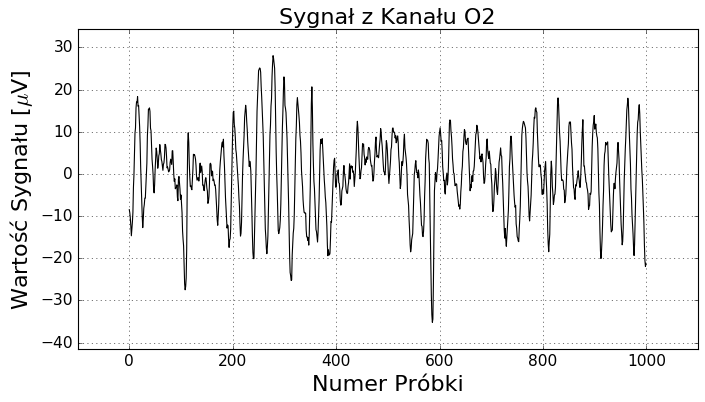

In [99]:
plt.style.use('classic')

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10, 5))

ax.plot(x[0], syg[0], 'k')
ax.margins(0.1, 0.1)
plt.title('Sygnał z Kanału O2', fontsize=20)
ax.set_facecolor('#ffffff')
ax.tick_params(labelsize=14)
ax.grid(True)


fig.patch.set_facecolor('#ffffff')

plt.ylabel('Wartość Sygnału [$\mu$V]', fontsize=20)
plt.xlabel('Numer Próbki', fontsize=20)
plt.show()
plt.close()

### Wizualizacja Kryterium Akaike

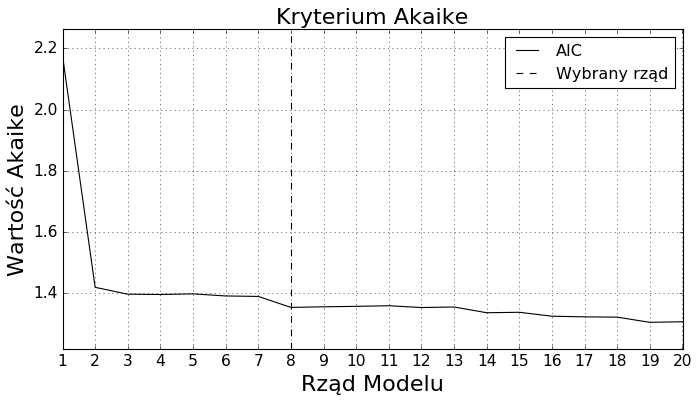

In [101]:
AIC = utils.coeffs(syg, 1, 5)
# for _x in AIC:
#   print(len(_x[0]), _x[0])
  
AIC = utils.get_aic_func(syg, 1, 20)
order, params, coefs = utils.best_akaike(syg, 1, 20)

# plt.figure()
# plt.plot(list(range(1, 21)), AIC)
# plt.scatter(order, np.log(np.linalg.det(coefs)) + 2 * order * syg.shape[0] * \
#             syg.shape[0] / syg.shape[1], color='r')
# plt.show()
# plt.close()

plt.style.use('classic')

chosen_order = 8

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10, 5))

ax.plot(list(range(1, 21)), AIC, 'k', label='AIC')
ax.axvline(chosen_order, color='k', linestyle='--', label='Wybrany rząd')

ax.margins(0.1, 0.1)
plt.title('Kryterium Akaike', fontsize=20)
ax.set_facecolor('#ffffff')
ax.set_xticks(np.arange(0, 21, 1))
ax.tick_params(labelsize=14)
ax.grid(True)

ax.legend(loc='upper right')

plt.xlabel('Rząd Modelu', fontsize=20)
plt.ylabel('Wartość Akaike', fontsize=20)

fig.patch.set_facecolor('#ffffff')

plt.xlim(1,20)
plt.show()
plt.close()



# Zadanie 2
Napisz funkcję obliczającą macierze A(f) i H(f) z równań (Equation 4) i (Equation 5) dla wybranego zestawu częstości z zakresu f0-fmax. Wykorzystaj tutaj równanie (Equation 12). Funkcja ma działać dla danych wielokanałowych (no i oczywiście jednokanałowych jako przypadek szczególny), tzn. jej argumentami powinny być: macierz zawierająca sygnał i rząd modelu.

Stosując napisaną funkcję oraz równanie (Equation 8) oblicz macierz gęstości widmowej mocy w zakresie częstości od 0 Hz do częstości Nyquista dla danych z poprzedniego ćwiczenia (z użyciem optymalnego rzędu modelu AR). Narysuj wykresy widm własnych i wzajemnych.

In [0]:
def widmo(s, order, f_max, Fs=128,df=1):
  efs = np.arange(0, f_max+1, df)

  k = np.shape(s)[0]
  
  widma = np.empty((efs.size, k, k), dtype="complex")
  
  coef, V = mtmvar.mult_AR(s, order, 1)
  coef *= -1
  
  for j, f in enumerate(efs):
    A = np.eye(k, dtype='complex')
  
    for i in range(len(coef)):
        A += coef[i,:,:] * np.exp(2 * 1j * np.pi * f / Fs)**(-i - 1)

    H = np.linalg.inv(A)
    
    w = np.dot(np.dot(H,V), np.conjugate(H.T))
    
    widma[j] = w
    
  return efs, widma


### Porównanie Widma z modelu AR i Fouriera

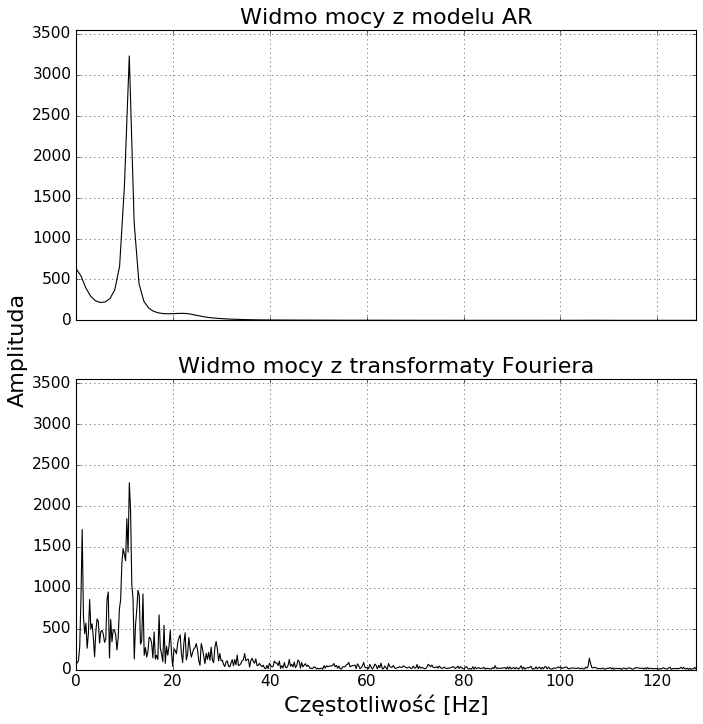

In [106]:
plt.style.use('classic')

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 10))

xf, S = widmo(syg, order, 128, fs)

ax[0].plot(xf, abs(S[:, 0]), 'k')
ax[0].margins(0.1, 0.1)
ax[0].set_title('Widmo mocy z modelu AR', fontsize=20)
ax[0].set_facecolor('#ffffff')
ax[0].tick_params(labelsize=14)
ax[0].grid(True)

S = np.fft.rfft(syg)
freq = np.fft.rfftfreq(syg.size, d=1./fs)

ax[1].plot(freq, abs(S[0,:]), 'k')
ax[1].margins(0.1, 0.1)
ax[1].set_title('Widmo mocy z transformaty Fouriera', fontsize=20)
ax[1].set_facecolor('#ffffff')
ax[1].tick_params(labelsize=14)
ax[1].grid(True)

plt.xlabel('Częstotliwość [Hz]', fontsize=20)
fig.text(0.04, 0.5, 'Amplituda', va='center', rotation='vertical', fontsize=20)

fig.patch.set_facecolor('#ffffff')
plt.xlim(0, fs//2)
plt.ylim(0, None)
plt.show()

plt.close()

# Zadanie 3
Wygeneruj dwa sygnały sinusoidalne o długości 1000 próbek każdy, o tej samej częstości 32 Hz i częstości próbkowania 128 Hz, ale różnych fazach początkowych.
Pierwszy sygnał powinien mieć fazę początkową równą 0, drugi sygnał sinusoidalny powinien mieć fazę początkową równą π/4.
Do drugiego z sygnałów dodaj małą (o amplitudzie ok 0,2 amplitudy sinusoidy) składową losową (czyli dodatkowy niezależny szum biały).
Z tak otrzymanych sygnałów utwórz jeden sygnał dwukanałowy (macierz o rozmiarze (2,1000)).
Podobnie jak poprzednio, ustal optymalny rząd modelu AR (tym razem dwukanałowego) i oblicz macierz gęstości widmowej mocy. Oblicz koherencje między tymi sygnałami. Narysuj moduł i fazę koherencji C12 i C21.

Zmień fazę początkową drugiego sygnału. Jak zmienia się funkcja koherencji?

In [0]:
def coherence(widmo, i, j, absoulte=True): 
  S = widmo[:, i, j] / (widmo[:, i, i] * widmo[:, j, j])**.5
  return np.abs(S) if absoulte else S

def sin(f=32,N=1000,Fs=128,phi=0): 
  dt = 1.0/Fs
  x = np.arange(0,N/Fs,dt)
  g = np.sin(2*np.pi*f*x + phi)
  return x, g

def noise(N): return np.random.uniform(-1,1, N)

def coherence_partial(widmo, i, j, absoulte=True): 
  S = np.linalg.inv([widmo[f,:] for f in range(widmo.shape[0])])
  S = (-1)**(i+j) * S[:, j, i] / (S[:, i, i] * S[:, j, j])**.5
  return np.abs(S) if absoulte else S

def plot_coherence(s, title='', low=1, high=5, shape=(4, 4), names=['$g_1$', '$g_2$', '$g_3$']):
  order, params, coefs = utils.best_akaike(s, low, high)
  efs, widma = widmo(s, order, 128//2, Fs=128)

  plt.style.use('classic')

  fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], sharex=True, sharey=True, figsize=(12, 10))

  for i, row in enumerate(ax):
      for j, col in enumerate(row):
          coh = coherence(widma, i, j)
          col.plot(efs, coh, 'k')
          col.margins(0.1, 0.1)
          col.set_title('{} {}'.format(names[i], names[j]), fontsize=20)
          col.set_ylim(-0.1, 1.25)
          col.set_facecolor('#ffffff')
          col.tick_params(labelsize=14)
          col.grid(True)

  fig.tight_layout()
  fig.patch.set_facecolor('#ffffff')

  fig.text(0.5, 1, title, ha='center', fontsize=24)
  fig.text(0.5, -0.01, 'Częstotliwość [Hz]', ha='center', fontsize=20)
  fig.text(-0.01, 0.5, 'Wartość Koherencji', va='center', rotation='vertical', fontsize=20)
  plt.xlim(min(efs), max(efs))
  plt.ylim(0, 1.1)
  fig.show()

def plot_partial_coherence(s, title='', low=1, high=5, shape=(4, 4), names=['$g_1$', '$g_2$', '$g_3$']):
  order, params, coefs = utils.best_akaike(s, low, high)
  efs, widma = widmo(s, order, 128//2, Fs=128)

  plt.style.use('classic')

  fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], sharex=True, sharey=True, figsize=(12, 10))

  for i, row in enumerate(ax):
      for j, col in enumerate(row):
          coh = coherence_partial(widma, i, j)
          col.plot(efs, coh, 'k')
          col.margins(0.1, 0.1)
          col.set_title('{} {}'.format(names[i], names[j]), fontsize=20)
          col.set_ylim(-0.1, 1.25)
          col.set_facecolor('#ffffff')
          col.tick_params(labelsize=14)
          col.grid(True)

  fig.tight_layout()
  fig.patch.set_facecolor('#ffffff')

  fig.text(0.5, 1, title, ha='center', fontsize=24)
  fig.text(0.5, -0.01, 'Częstotliwość [Hz]', ha='center', fontsize=20)
  fig.text(-0.01, 0.5, 'Wartość Koherencji Cząstkowej', va='center', rotation='vertical', fontsize=20)
  plt.xlim(min(efs), max(efs))
  plt.ylim(0, 1.1)
  fig.show()

### Wpływ zmiany fazy cząstkowej na Kocherencje

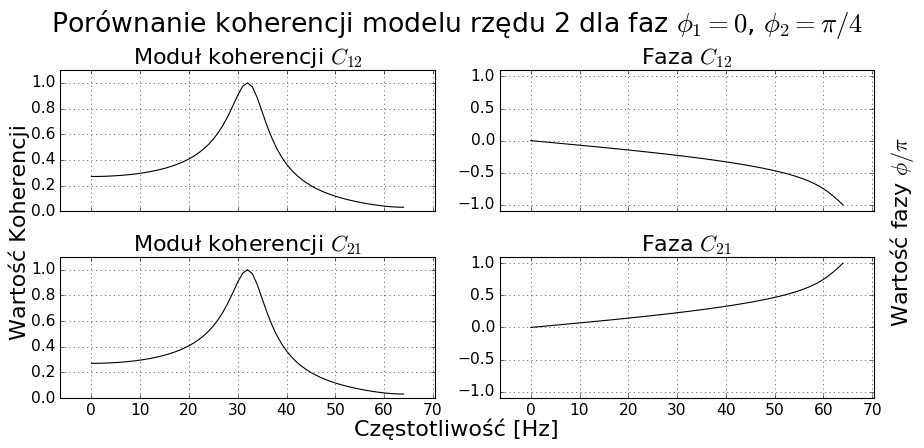

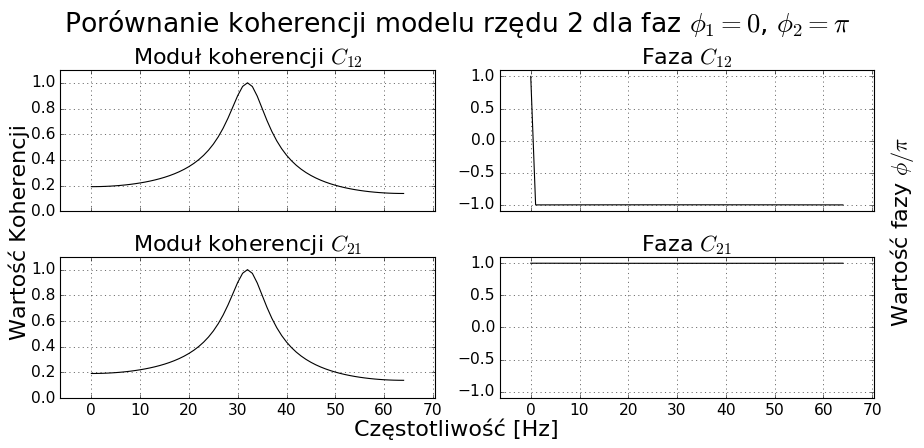

In [108]:
plt.style.use('classic')

x, g1 = sin()
x, g2 = sin(phi = np.pi/4)

g2 += noise(g2.size) * 0.2

syg = np.array([g1, g2])

order, params, coefs = utils.best_akaike(syg, 1, 20)

efs, widma = widmo(syg, order, 128//2, Fs=128)

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(11, 5))

coh = coherence(widma, 0, 1, absoulte=False)

ax[0, 0].plot(efs, abs(coh), 'k')
ax[0, 0].margins(0.1, 0.1)
ax[0, 0].set_title('Moduł koherencji $C_{12}$', fontsize=20)
ax[0, 0].set_ylim(0, 1.1)
ax[0, 0].set_facecolor('#ffffff')
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].grid(True)

ax[0, 1].plot(efs, np.angle(coh)/np.pi, 'k')
ax[0, 1].margins(0.1, 0.1)
ax[0, 1].set_title('Faza $C_{12}$', fontsize=20)
ax[0, 1].set_ylim(-1.1, 1.1)
ax[0, 1].set_facecolor('#ffffff')
ax[0, 1].tick_params(labelsize=14)
ax[0, 1].grid(True)

# fig.tight_layout()
# fig.patch.set_facecolor('#ffffff')

# fig.text(0.5, 1, 'Koherencja dla $\phi = \pi / 4$', ha='center', fontsize=24)
# fig.text(0.5, -0.01, 'Częstotliwość [Hz]', ha='center', fontsize=20)
# fig.text(-0.01, 0.5, 'Wartość Koherencji', va='center', rotation='vertical', fontsize=20)



# fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(11, 5))
coh = coherence(widma, 1, 0, absoulte=False)

ax[1, 0].plot(efs, abs(coh), 'k')
ax[1, 0].margins(0.1, 0.1)
ax[1, 0].set_title('Moduł koherencji $C_{21}$', fontsize=20)
ax[1, 0].set_ylim(0, 1.1)
ax[1, 0].set_facecolor('#ffffff')
ax[1, 0].tick_params(labelsize=14)
ax[1, 0].grid(True)

ax[1, 1].plot(efs, np.angle(coh)/np.pi, 'k')
ax[1, 1].margins(0.1, 0.1)
ax[1, 1].set_title('Faza $C_{21}$', fontsize=20)
ax[1, 1].set_ylim(-1.1, 1.1)
ax[1, 1].set_facecolor('#ffffff')
ax[1, 1].tick_params(labelsize=14)
ax[1, 1].grid(True)

fig.tight_layout()
fig.patch.set_facecolor('#ffffff')

fig.text(0.5, 1, 'Porównanie koherencji modelu rzędu %s dla faz $\phi_1=0$, $\phi_2=\pi/4$'%order, ha='center', fontsize=24)
fig.text(0.5, -0.01, 'Częstotliwość [Hz]', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Wartość Koherencji', va='center', rotation='vertical', fontsize=20)
fig.text(0.99, 0.5, 'Wartość fazy $\phi/\pi$', va='center', rotation='vertical', fontsize=20)
plt.show()

x, g1 = sin()
x, g2 = sin(phi = np.pi)

g2 += noise(g2.size) * 0.2

syg = np.array([g1, g2])

order, params, coefs = utils.best_akaike(syg, 1, 20)

efs, widma = widmo(syg, order, 128//2, Fs=128)

coh = coherence(widma, 0, 1, absoulte=False)

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(11, 5))

ax[0, 0].plot(efs, abs(coh), 'k')
ax[0, 0].margins(0.1, 0.1)
ax[0, 0].set_title('Moduł koherencji $C_{12}$', fontsize=20)
ax[0, 0].set_ylim(0, 1.1)
ax[0, 0].set_facecolor('#ffffff')
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].grid(True)

ax[0, 1].plot(efs, np.angle(coh)/np.pi, 'k')
ax[0, 1].margins(0.1, 0.1)
ax[0, 1].set_title('Faza $C_{12}$', fontsize=20)
ax[0, 1].set_ylim(-1.1, 1.1)
ax[0, 1].set_facecolor('#ffffff')
ax[0, 1].tick_params(labelsize=14)
ax[0, 1].grid(True)

# fig.tight_layout()
# fig.patch.set_facecolor('#ffffff')

# fig.text(0.5, 1, 'Koherencja dla $\phi = \pi / 4$', ha='center', fontsize=24)
# fig.text(0.5, -0.01, 'Częstotliwość [Hz]', ha='center', fontsize=20)
# fig.text(-0.01, 0.5, 'Wartość Koherencji', va='center', rotation='vertical', fontsize=20)



# fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(11, 5))
coh = coherence(widma, 1, 0, absoulte=False)

ax[1, 0].plot(efs, abs(coh), 'k')
ax[1, 0].margins(0.1, 0.1)
ax[1, 0].set_title('Moduł koherencji $C_{21}$', fontsize=20)
ax[1, 0].set_ylim(0, 1.1)
ax[1, 0].set_facecolor('#ffffff')
ax[1, 0].tick_params(labelsize=14)
ax[1, 0].grid(True)

ax[1, 1].plot(efs, np.angle(coh)/np.pi, 'k')
ax[1, 1].margins(0.1, 0.1)
ax[1, 1].set_title('Faza $C_{21}$', fontsize=20)
ax[1, 1].set_ylim(-1.1, 1.1)
ax[1, 1].set_facecolor('#ffffff')
ax[1, 1].tick_params(labelsize=14)
ax[1, 1].grid(True)


fig.tight_layout()
fig.patch.set_facecolor('#ffffff')

fig.text(0.5, 1, 'Porównanie koherencji modelu rzędu %s dla faz $\phi_1=0$, $\phi_2=\pi$'%order, ha='center', fontsize=24)
fig.text(0.5, -0.01, 'Częstotliwość [Hz]', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Wartość Koherencji', va='center', rotation='vertical', fontsize=20)
fig.text(0.99, 0.5, 'Wartość fazy $\phi/\pi$', va='center', rotation='vertical', fontsize=20)
plt.show()

# Zadanie 4

Wygeneruj układ trzech sygnałów w następujący sposób:

* jako pierwszego kanału użyj sygnału z ćwiczenia 3;
* sygnał_w_drugim_kanale(t) = 0,4 * sygnał_z_pierwszego_kanału(t−1) + szum1;
* sygnał_w_trzecim_kanale(t) = 0,3 * sygnał_z_pierwszego_kanału(t−2) + szum2.

Oblicz macierz koherencji zwyczajnych dla tego układu i na ich podstawie wyznacz zależności między kanałami. Powtórz to samo dla koherencji cząstkowych.

Wygeneruj zestaw danych jak poprzednio używając w kanale 1 sygnału z ćwiczenia 1. Powtórz obliczenia i porównaj wyniki.

Wyniki wszystkich obliczeń przedstaw na rysunkach.

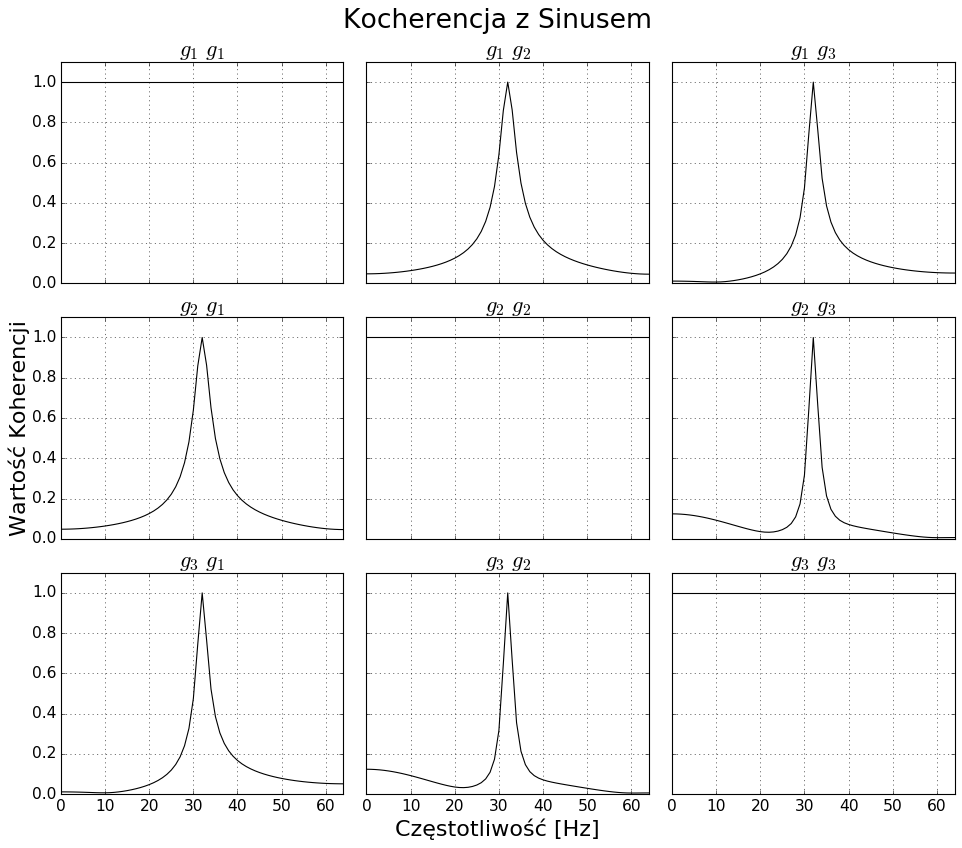

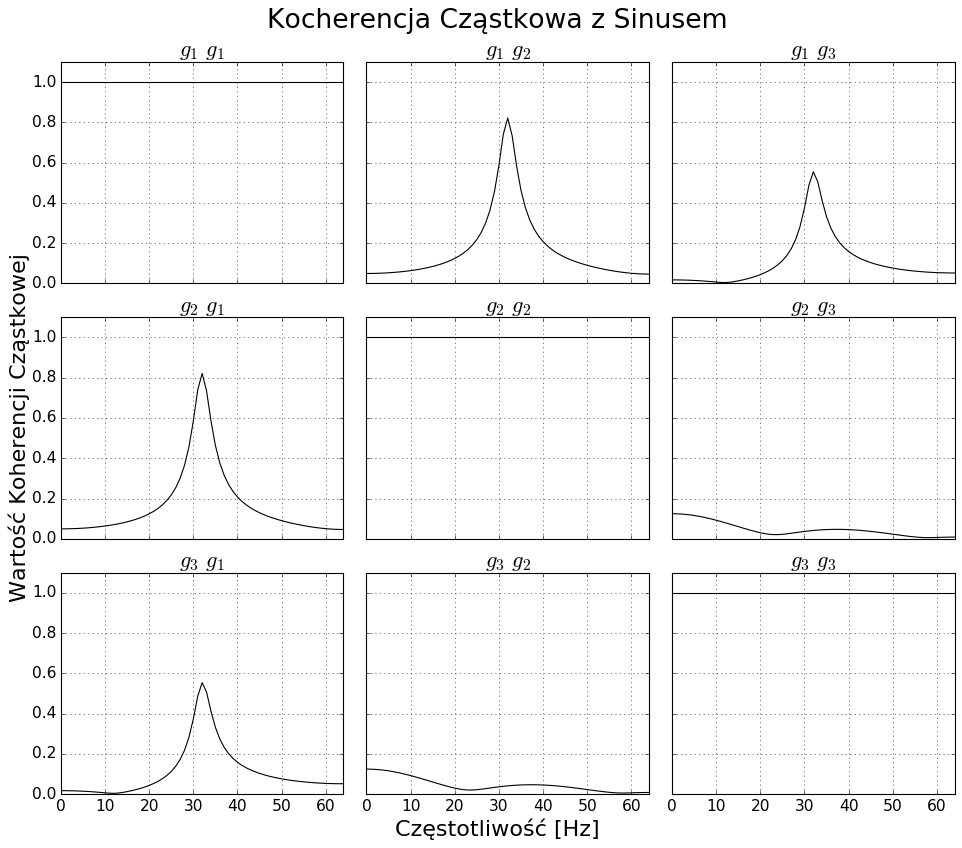

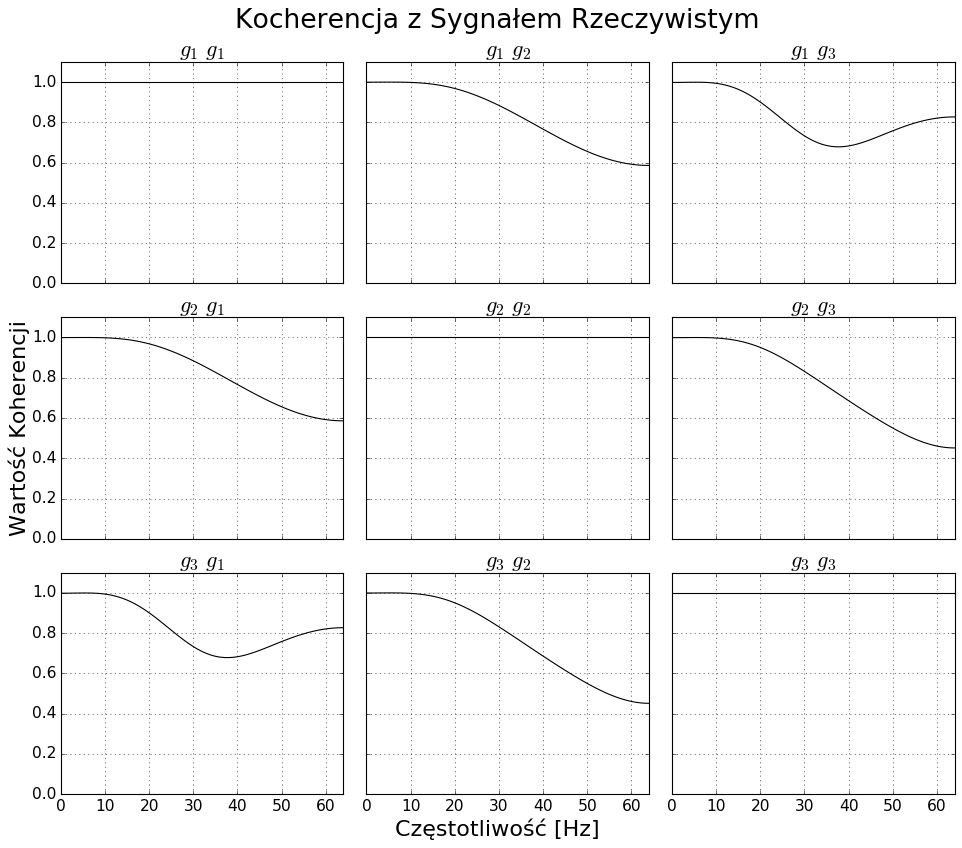

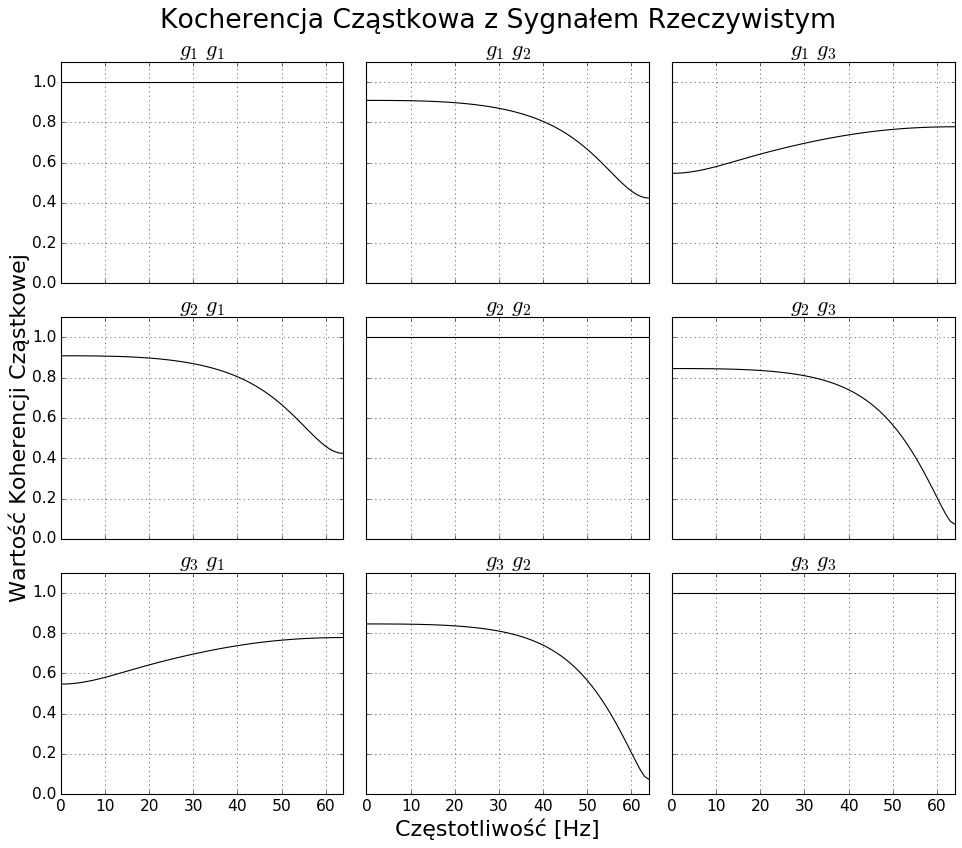

In [109]:
x, g = sin(f=32, N=1002, Fs=128, phi=0)
x, g1 = x[2:], g[2:]
g2 = 0.4 * np.copy(g[1:-1]) + noise(g1.size) * 0.2
g3 = 0.3 * np.copy(g[0:-2]) + noise(g1.size) * 0.2

syg = np.array([g1,g2,g3])

plot_coherence(syg, 'Kocherencja z Sinusem', 1, 5, shape=(3, 3))
plot_partial_coherence(syg, 'Kocherencja Cząstkowa z Sinusem', 1, 5, shape=(3, 3))

x = np.arange(fs + 2)/fs
g = np.copy(s[0, s.size//2 : s.size//2 + 1002])
x, g1 = x[2:], g[2:]
g2 = 0.4 * g[1:-1] + noise(g1.size) * 0.2
g3 = 0.3 * g[0:-2] + noise(g1.size) * 0.2

syg = np.array([g1,g2,g3])

plot_coherence(syg, 'Kocherencja z Sygnałem Rzeczywistym', 1, 5, shape=(3, 3))
plot_partial_coherence(syg, 'Kocherencja Cząstkowa z Sygnałem Rzeczywistym', 1, 5, shape=(3, 3))





# Zadanie 5
Z danych zawierających spoczynkowe EEG wytnij dwa fragmenty: zawierający i nie zawierający czynności alfa. Fragmenty powinny mieć cztery wybrane kanały danych (dwa z tyłu i dwa z przodu głowy, na przykład O1, O2, F3, F4) oraz długość ok. 500 próbek.

Dopasuj czterokanałowe modele AR do wyciętych fragmentów danych. Oblicz macierze gęstości widmowej mocy, koherencji zwyczajnych i koherencji cząstkowych dla obu fragmentów. Narysuj wykresy otrzymanych funkcji.

In [93]:
otwarte = 'otwarte'
zamkniete = 'zamkniete'

filename_template = 'gdrive/My Drive/pracowniaEEG/cw1/{}'
filenames = [
    zamkniete,
    otwarte
]

syg = {}

for fname in filenames:
  filename = filename_template.format(fname)

  mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)

  fs = int(float(mgr.get_param("sampling_frequency")))
  num_of_channels = int(mgr.get_param("number_of_channels"))
  channels_names = mgr.get_param("channels_names")

  raw_syg_open = mgr.get_microvolt_samples()
  t = np.arange(raw_syg_open.shape[1])/fs

  choosen_channels = ["O2", "O1", "F4", "F3"]
  
  syg[fname] = np.empty((4, 500))
  
  for idx, choosen_channel in enumerate(choosen_channels):
    _s = (raw_syg_open[channels_names.index(choosen_channel),:])
    _s = filters.butter_highpass_filter(_s, 1, fs, order=5)
    _s = filters.notch_filter(_s, 50, fs)
    
    syg[fname][idx] = _s[len(_s)//2 : len(_s)//2 + 500]
  
  del(raw_syg_open)

  x = np.arange(syg[fname].shape[1])
  x = x.reshape(1, x.size)


2019-02-16 03:42:27,677 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...
2019-02-16 03:42:37,039 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


### Koherencje

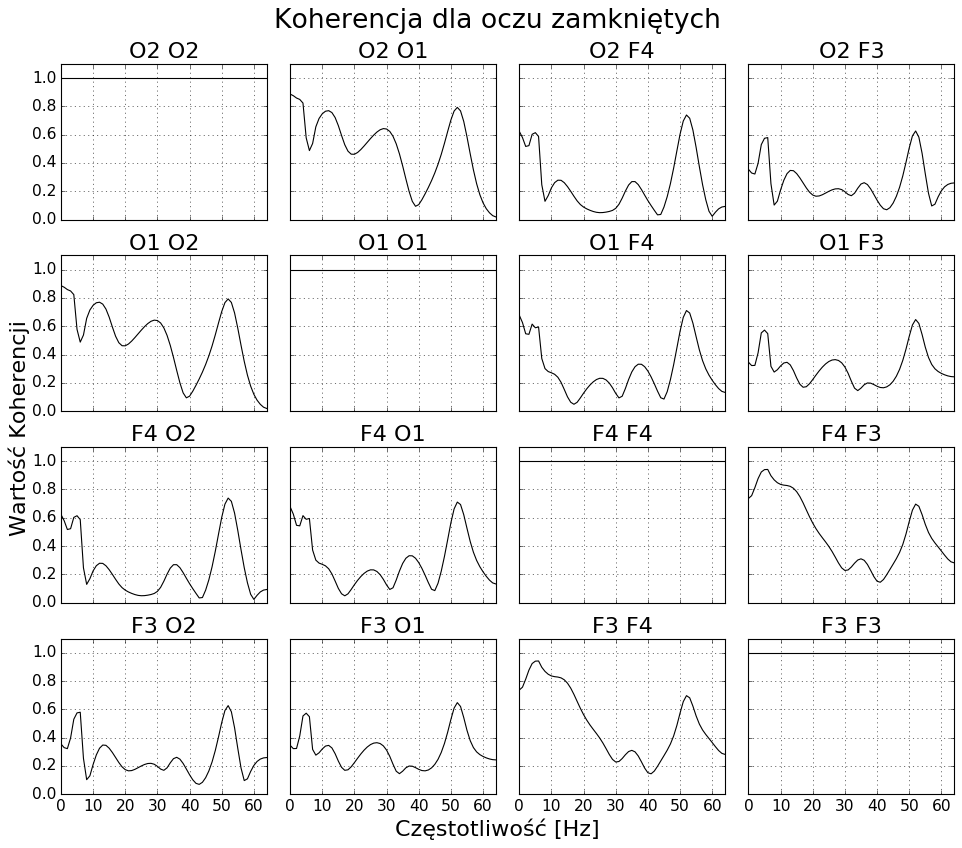

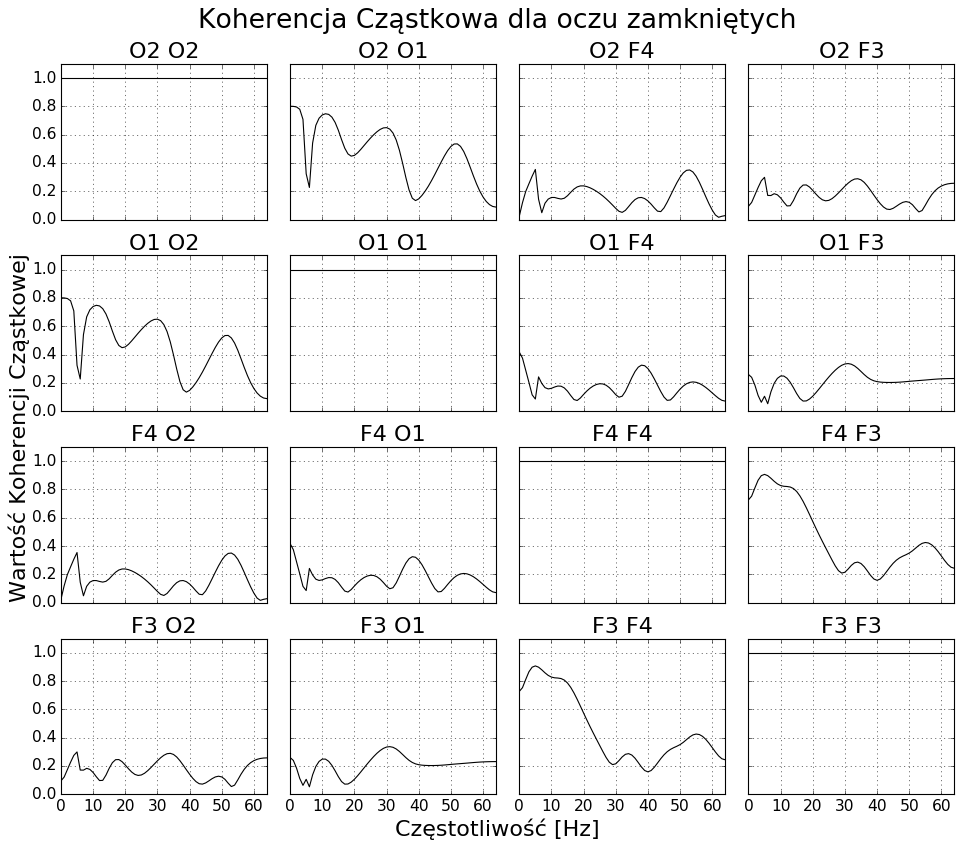

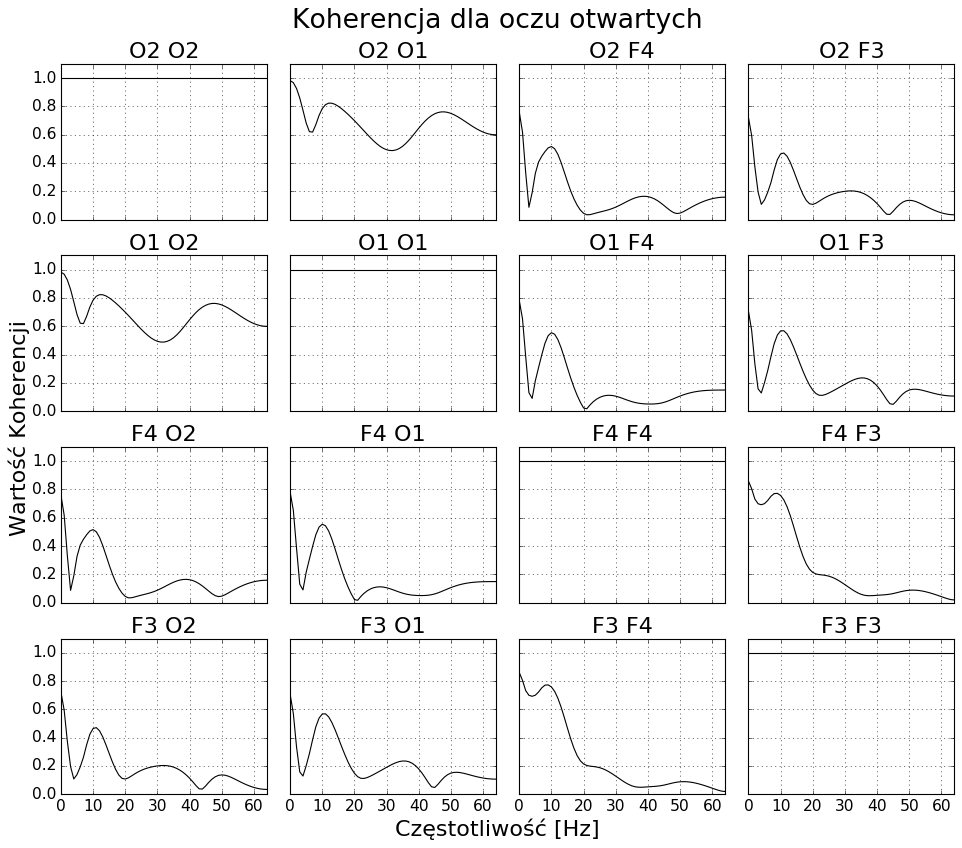

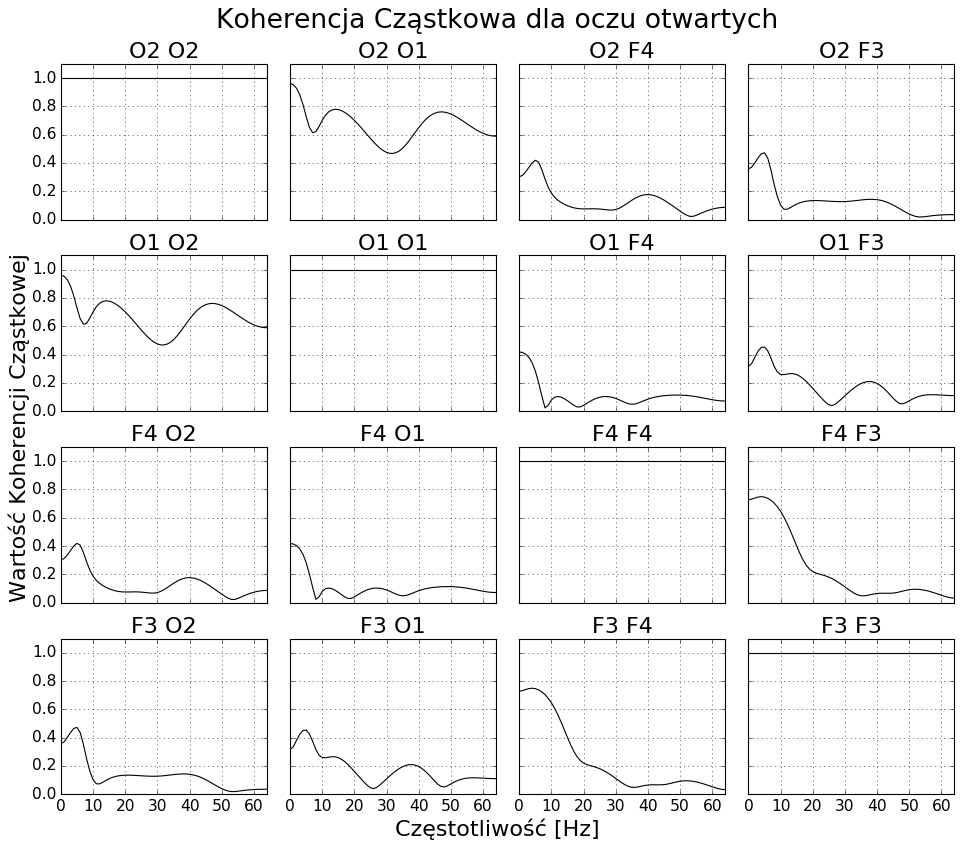

In [94]:
plot_coherence(syg[zamkniete], 'Koherencja dla oczu zamkniętych', 1, 20, (4, 4), names=choosen_channels)
plot_partial_coherence(syg[zamkniete], 'Koherencja Cząstkowa dla oczu zamkniętych', 1, 20, (4, 4), names=choosen_channels)

plot_coherence(syg[otwarte], 'Koherencja dla oczu otwartych', 1, 20, (4, 4), names=choosen_channels)
plot_partial_coherence(syg[otwarte], 'Koherencja Cząstkowa dla oczu otwartych', 1, 20, (4, 4), names=choosen_channels)